**SVR MODEL FOR HOUSE PRICES**

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
# fetch data
df = pd.read_csv('train.csv')
y = np.asarray(df.loc[:,'SalePrice'].values.astype(int))
mask = len(y)
df_forecast = pd.read_csv('test.csv')
NaN = np.nan
df_forecast['SalePrice'] = NaN

# merge train and test data for data manipulation
df = pd.concat([df, df_forecast], sort=False)
df2 = df.copy()

del df2['Id']

# all below from https://www.kaggle.com/juliensiems/cleaning-new-features-gps-coordinates-included

# replace missing values with zeros
ls = ['BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'GarageArea', 'GarageCars',
     'KitchenAbvGr', 'LotFrontage', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea',
      'ScreenPorch', 'TotRmsAbvGrd', 'WoodDeckSF']
for f in ls:
    df2[f].fillna(0, inplace=True)
    
# relace missing values with labels
ls_no = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Fence',
        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MiscFeature','PoolQC']
for f in ls_no:
    df2[f].fillna("No", inplace=True)
    
# replace missing values with other labels
ls_ta = ['ExterCond', 'ExterQual', 'HeatingQC', 'KitchenQual']
ls_norm = ['Condition1', 'Condition2']
for f in ls_ta:
    df2[f].fillna("TA", inplace=True)
for f in ls_norm:
    df2[f].fillna("Norm", inplace=True)

df2['Alley'].fillna('None', inplace=True)
df2['CentralAir'].fillna('N', inplace=True)
df2['PavedDrive'].fillna('N', inplace=True)
df2['Functional'].fillna('Typ', inplace=True)
df2['LotShape'].fillna('Reg', inplace=True)
df2['MasVnrType'].fillna('None', inplace=True)
df2['SaleCondition'].fillna('Normal', inplace=True)
df2['Utilities'].fillna('AllPub', inplace=True)

# add features to replace neighborhood by its coordinates
df2['lat'] = df2['Neighborhood'].replace({'Blmngtn' : 42.062806,
                                               'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})

df2['lon'] = df2['Neighborhood'].replace({'Blmngtn' : -93.639963,
                                               'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

# create new features by combining existing features
df2['IsRegularLotShape'] = (df2['LotShape'] =='Reg') * 1
df2['IsLandLevel'] = (df2['LandContour'] == 'Lvl') * 1
df2['IsLandSlopeGentle'] = (df2['LandSlope'] == 'Gtl') * 1
df2['IsElectricalSBrkr'] = (df2['Electrical'] == 'SBrkr') * 1
df2['IsGarageDetached'] = (df2['GarageType'] == 'Detchd') * 1
df2['IsPavedDrive'] = (df2['PavedDrive'] == 'Y') * 1
df2['HasShed'] = (df2['MiscFeature'] == 'Shed') * 1.
df2['Remodeled'] = (df2['YearRemodAdd'] != df2['YearBuilt']) * 1
df2['RecentRemodel'] = (df2['YearRemodAdd'] == df2['YrSold']) * 1
df2['VeryNewHouse'] = (df2['YearBuilt'] == df2['YrSold']) * 1
df2['HasMasVnr'] = (df2['MasVnrArea'] == 0) * 1
df2['HasWoodDeck'] = (df2['WoodDeckSF'] == 0) * 1
df2['HasOpenPorch'] = (df2['OpenPorchSF'] == 0) * 1
df2['HasEnclosedPorch'] = (df2['EnclosedPorch'] == 0) * 1
df2['Has3SsnPorch'] = (df2['3SsnPorch'] == 0) * 1
df2['HasScreenPorch'] = (df2['ScreenPorch'] == 0) * 1

# encode categorical variables
df2 = df2.replace({'Alley' : {'Grvl' : 1, 'Pave' : 2},
                           'BsmtCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'BsmtExposure' : {'No' : 0, 'Mn' : 1, 'Av': 2, 'Gd' : 3},
                           'BsmtFinType1' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4,
                                             'ALQ' : 5, 'GLQ' : 6},
                           'BsmtFinType2' : {'No' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4,
                                             'ALQ' : 5, 'GLQ' : 6},
                           'BsmtQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd' : 4, 'Ex' : 5},
                           'ExterCond' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
                           'ExterQual' : {'Po' : 1, 'Fa' : 2, 'TA': 3, 'Gd': 4, 'Ex' : 5},
                           'FireplaceQu' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'Functional' : {'Sal' : 1, 'Sev' : 2, 'Maj2' : 3, 'Maj1' : 4, 'Mod': 5,
                                           'Min2' : 6, 'Min1' : 7, 'Typ' : 8},
                           'GarageCond' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'GarageQual' : {'No' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'HeatingQC' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'KitchenQual' : {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5},
                           'LandSlope' : {'Sev' : 1, 'Mod' : 2, 'Gtl' : 3},
                           'LotShape' : {'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4},
                           'PavedDrive' : {'N' : 0, 'P' : 1, 'Y' : 2},
                           'PoolQC' : {'No' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4},
                           'Street' : {'Grvl' : 1, 'Pave' : 2},
                           'Utilities' : {'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4}})

# simplify existing features
df2['SimplOverallQual'] = df2.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
df2['SimplOverallCond'] = df2.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
df2['SimplPoolQC'] = df2.PoolQC.replace({1 : 1, 2 : 1, # average
                                                 3 : 2, 4 : 2 # good
                                                })
df2['SimplGarageCond'] = df2.GarageCond.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
df2['SimplGarageQual'] = df2.GarageQual.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
df2['SimplFireplaceQu'] = df2.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
df2['SimplFireplaceQu'] = df2.FireplaceQu.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
df2['SimplFunctional'] = df2.Functional.replace({1 : 1, 2 : 1, # bad
                                                         3 : 2, 4 : 2, # major
                                                         5 : 3, 6 : 3, 7 : 3, # minor
                                                         8 : 4 # typical
                                                        })
df2['SimplKitchenQual'] = df2.KitchenQual.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
df2['SimplHeatingQC'] = df2.HeatingQC.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df2['BadHeating'] = df2.HeatingQC.replace({1 : 1, # bad
                                                       2 : 0, 3 : 0, # average
                                                       4 : 0, 5 : 0 # good
                                                      })
df2['SimplBsmtFinType1'] = df2.BsmtFinType1.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
df2['SimplBsmtFinType2'] = df2.BsmtFinType2.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
df2['SimplBsmtCond'] = df2.BsmtCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df2['SimplBsmtQual'] = df2.BsmtQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df2['SimplExterCond'] = df2.ExterCond.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df2['SimplExterQual'] = df2.ExterQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })

# combining existing features
df2['OverallGrade'] = df2['OverallQual'] * df2['OverallCond']
df2['GarageGrade'] = df2['GarageQual'] * df2['GarageCond']
df2['ExterGrade'] = df2['ExterQual'] * df2['ExterCond']
df2['KitchenScore'] = df2['KitchenAbvGr'] * df2['KitchenQual']
df2['FireplaceScore'] = df2['Fireplaces'] * df2['FireplaceQu']
df2['GarageScore'] = df2['GarageArea'] * df2['GarageQual']
df2['PoolScore'] = df2['PoolArea'] * df2['PoolQC']
df2['SimplOverallGrade'] = df2['SimplOverallQual'] * df2['SimplOverallCond']
df2['SimplExterGrade'] = df2['SimplExterQual'] * df2['SimplExterCond']
df2['SimplPoolScore'] = df2['PoolArea'] * df2['SimplPoolQC']
df2['SimplGarageScore'] = df2['GarageArea'] * df2['SimplGarageQual']
df2['SimplFireplaceScore'] = df2['Fireplaces'] * df2['SimplFireplaceQu']
df2['SimplKitchenScore'] = df2['KitchenAbvGr'] * df2['SimplKitchenQual']
df2['TotalBath'] = df2['BsmtFullBath'] + (0.5 * df2['BsmtHalfBath']) + df2['FullBath'] + (0.5 * df2['HalfBath'])
df2['AllSF'] = df2['GrLivArea'] + df2['TotalBsmtSF']
df2['AllFlrsSF'] = df2['1stFlrSF'] + df2['2ndFlrSF']
df2['AllPorchSF'] = df2['OpenPorchSF'] + df2['EnclosedPorch'] + df2['3SsnPorch'] + df2['ScreenPorch']
df2['HasMasVnr'] = df2.MasVnrType.replace({'BrkCmn' : 1, 'BrkFace' : 1, 'CBlock' : 1,
                                                   'Stone' : 1, 'None' : 0})
df2['SaleCondition_PriceDown'] = df2.SaleCondition.replace({'Abnorml': 1,
                                                              'Alloca': 1,
                                                              'AdjLand': 1,
                                                              'Family': 1,
                                                              'Normal': 0,
                                                              'Partial': 0})

df2['BoughtOffPlan'] = df2.SaleCondition.replace({'Abnorml' : 0, 'Alloca' : 0, 'AdjLand' : 0,
                                                          'Family' : 0, 'Normal' : 0, 'Partial' : 1})

# taken from https://www.kaggle.com/yadavsarthak/house-prices-advanced-regression-techniques/you-got-this-feature-engineering-and-lasso
df2['1stFlr_2ndFlr_Sf'] = np.log1p(df2['1stFlrSF'] + df2['2ndFlrSF'])
df2['All_Liv_SF'] = np.log1p(df2['1stFlr_2ndFlr_Sf'] + df2['LowQualFinSF'] + df2['GrLivArea'])

# split between numerical and categorical features
df_num = df2.select_dtypes(include = ['float64', 'int64']) # 109 features + SalePrice
del df_num['SalePrice']
df_num = pd.concat([df_num, df['SalePrice']], axis=1, sort=False)
df_cat = df2[[i for i in df2 if i not in df_num.columns.tolist()[:-1]]] # 25 features + SalePrice

# map the following categorical features: 
cat_to_map = ['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle', 
             'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
             'Heating', 'CentralAir', 'Electrical', 'GarageType', 'Fence', 'MiscFeature', 'SaleType']

ord_to_map = ['Condition1', 'Condition2', 'SaleCondition', 'GarageFinish']
 
df_cat_replace = df_cat.copy()
df_cat_replace = df_cat_replace[cat_to_map + ord_to_map + ['SalePrice']] # 22 categorical variables + SalePrice

# map categorical features
df_cat_replace = pd.get_dummies(df_cat_replace, columns=cat_to_map, prefix=cat_to_map)

# map ordinal variables:              
for i in range(len(ord_to_map)):
    labels = df_cat[ord_to_map[i]].astype('category').cat.categories.tolist()
    replace_map = {ord_to_map[i]: {k: v for k,v in zip(labels, list(range(1, len(labels)+1)))}}
    df_cat_replace.replace(replace_map, inplace=True)
    
df_cat_mapped = df_cat_replace.copy()
del df_cat_mapped['SalePrice']
df_num_replace = pd.concat([df_cat_mapped, df_num.copy()], axis=1, sort=False)
print(df_num_replace.columns.tolist())

['Condition1', 'Condition2', 'SaleCondition', 'GarageFinish', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Alley_1', 'Alley_2', 'Alley_None', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'Bldg

In [3]:
# filter the features resulting from EDA
features_selected =['1stFlrSF','AllFlrsSF','AllSF','BsmtQual','ExterGrade','ExterQual','FireplaceQu',
                             'Foundation_PConc', 'FullBath','GarageCars','GarageScore','GarageYrBlt','KitchenQual',
                             'MasVnrArea','OverallGrade','OverallQual','TotalBath','TotalBsmtSF','TotRmsAbvGrd',
                             'YearBuilt','YearRemodAdd']

features_selected = [i for i in features_selected if i in df_num_replace.columns[:-1].tolist()]
df_X = df_num_replace.copy()[features_selected]

# replace all remaining null values
#df_X.replace('', np.nan)
df_X.replace(r'\s+', np.nan, regex=True)
df_X = df_X.apply(lambda x: x.fillna(x.mean()), axis=0)

# split features observations for train and forecast
X = np.asarray(df_X[:mask])
X_forecast = np.asarray(df_X[mask:])
print(X.shape, X_forecast.shape, y.shape)

(1460, 21) (1459, 21) (1460,)


In [4]:
# split the dataset in train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1314, 21) (1314,)
Test set: (146, 21) (146,)


In [5]:
# set the parameters by cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('estimator', SVR())])
param_grid=dict(estimator__kernel = ['linear', 'rbf'],
                estimator__C = [1, 1.5, 1.75, 2, 2.25, 2.5, 3, 3.5, 4, 4.5],
                estimator__epsilon = [0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.15, 0.2])

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.ravel())
print(search.best_params_)
#{'estimator__C': 2, 'estimator__epsilon': 0.09, 'estimator__kernel': 'rbf'}

{'estimator__C': 2, 'estimator__epsilon': 0.09, 'estimator__kernel': 'rbf'}


In [6]:
# prediction for the validation set
yhat = y_scaler.inverse_transform(search.predict(X_test))
yhat[0:5]

array([206802.33612197, 205880.28625011, 147262.79774312, 146684.30468987,
       108825.2754469 ])

21701.751403985156


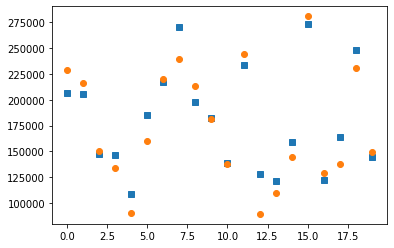

In [7]:
# plot a few predictions versus outcomes
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(y_test, yhat))
print(rms)

x = np.arange(20)
plt.plot(x, yhat[0:20], marker = 's', linestyle = 'None')
plt.plot(x, y_test[0:20], marker = 'o', linestyle = 'None')
plt.show()

In [8]:
# prediction based on provided test series
yhat = y_scaler.inverse_transform(search.predict(X_forecast))
yhat[0:5]
pd.DataFrame(yhat).to_csv('yhat.csv')